# GIS

In [1]:
import leafmap

coords = (-70.65, 46.10)
m = leafmap.Map(center=(coords[1], coords[0]), zoom=8, basemap="USGS Hydrography")

In [2]:
import xhydro.gis as xhgis

gdf = xhgis.watershed_delineation(coordinates=coords, map=m)
m

Map(center=[46.1, -70.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [3]:
wat = xhgis.watershed_properties(gdf)
wat

,HYBAS_ID,Upstream Area (sq. km).,category,color,area,perimeter,gravelius,centroid
0,7120380900,3037.4,1,#ffffd9,3.053232e+09,373015.315121,1.904328,"(-70.69631488574481, 45.7466334393053)"


In [4]:
surf = xhgis.surface_properties(gdf)
surf

,elevation,slope,aspect,gsd,epsg,time,band,platform,proj:shape,proj:epsg,spatial_ref
geometry,,,,,,,,,,,
0,458.578369,2.539031,184.549438,90,4326,2021-04-22,data,TanDEM-X,{1200},4326,0


In [10]:
# prop = xhgis.land_use_classification(gdf, unique_id="HYBAS_ID", output_format="xarray")
# prop

  0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 80B
Dimensions:                 (HYBAS_ID: 1)
Coordinates:
  * HYBAS_ID                (HYBAS_ID) int64 8B 7120380900
Data variables:
    pct_trees               (HYBAS_ID) float64 8B 0.8423
    pct_crops               (HYBAS_ID) float64 8B 0.03002
    pct_rangeland           (HYBAS_ID) float64 8B 0.08641
    pct_water               (HYBAS_ID) float64 8B 0.02103
    pct_built_area          (HYBAS_ID) float64 8B 0.01933
    pct_bare_ground         (HYBAS_ID) float64 8B 0.0001926
    pct_snow/ice            (HYBAS_ID) float64 8B 0.000113
    pct_flooded_vegetation  (HYBAS_ID) float64 8B 0.0005525
    pct_clouds              (HYBAS_ID) float64 8B 7.544e-07
Attributes:
    year:                2023
    collection:          io-lulc-annual-v02
    spatial_resolution:  10

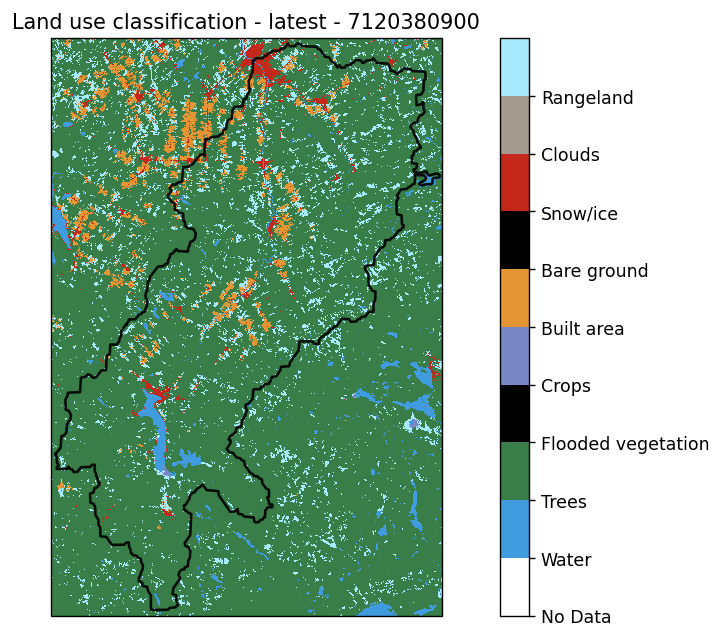

In [12]:
# lu = xhgis.land_use_plot(gdf, unique_id="HYBAS_ID", idx=0)

# Historical Data

In [5]:
import dask
import xarray as xr
import xclim
import xscen

In [6]:
meteo_ref = xr.open_dataset(
    "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5-Land_NAM.ncml",
    engine="netcdf4",
    chunks={"time": 365, "lon": 50, "lat": 50},
)[["pr", "tasmin", "tasmax"]]
meteo_ref = meteo_ref.sel(time=slice("1991", "2020"))
meteo_ref = xscen.spatial.subset(meteo_ref, method="shape", tile_buffer=2, shape=gdf)
meteo_ref = meteo_ref.assign_coords({"crs": meteo_ref.crs})
meteo_ref

<xarray.Dataset> Size: 22MB
Dimensions:  (time: 10958, lat: 13, lon: 13)
Coordinates:
  * lat      (lat) float32 52B 45.1 45.2 45.3 45.4 45.5 ... 46.0 46.1 46.2 46.3
  * lon      (lon) float32 52B -71.3 -71.2 -71.1 -71.0 ... -70.3 -70.2 -70.1
  * time     (time) datetime64[ns] 88kB 1991-01-01 1991-01-02 ... 2020-12-31
    crs      int64 8B 1
Data variables:
    pr       (time, lat, lon) float32 7MB dask.array<chunksize=(355, 13, 13), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 7MB dask.array<chunksize=(355, 13, 13), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 7MB dask.array<chunksize=(355, 13, 13), meta=np.ndarray>
Attributes: (12/27)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    license_type:         permissive
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac
    crs:                  EPSG:4326

In [7]:
meteo_ref = xscen.spatial_mean(
    meteo_ref,
    method="xesmf",
    region={"method": "shape", "shape": gdf},
    simplify_tolerance=0.1,
)
for c in meteo_ref.coords:
    if len(meteo_ref[c].dims) == 0:
        meteo_ref[c] = meteo_ref[c].expand_dims("HYBAS_ID")
meteo_ref

<xarray.Dataset> Size: 219kB
Dimensions:                  (time: 10958, HYBAS_ID: 1)
Coordinates:
  * time                     (time) datetime64[ns] 88kB 1991-01-01 ... 2020-1...
    lon                      (HYBAS_ID) float64 8B -70.7
    lat                      (HYBAS_ID) float64 8B 45.74
    geom                     (HYBAS_ID) int64 8B 0
  * HYBAS_ID                 (HYBAS_ID) int64 8B 7120380900
    Upstream Area (sq. km).  (HYBAS_ID) float64 8B 3.037e+03
    category                 (HYBAS_ID) int64 8B 1
    color                    (HYBAS_ID) object 8B '#ffffd9'
Data variables:
    pr                       (time) float32 44kB dask.array<chunksize=(355,), meta=np.ndarray>
    tasmin                   (time) float32 44kB dask.array<chunksize=(355,), meta=np.ndarray>
    tasmax                   (time) float32 44kB dask.array<chunksize=(355,), meta=np.ndarray>
Attributes: (12/28)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac
    crs:                  EPSG:4326
    regrid_method:        conservative

In [8]:
meteo_ref["tasmax"] = xclim.core.units.convert_units_to(
    meteo_ref["tasmax"], "degC"
)  # Convert from degK to degC
meteo_ref["tasmin"] = xclim.core.units.convert_units_to(
    meteo_ref["tasmin"], "degC"
)  # Convert from degK to degC

meteo_ref["pr"] = xclim.core.units.convert_units_to(
    meteo_ref["pr"], "mm d-1"
)  # Convert from m/d to mm/d
meteo_ref

<xarray.Dataset> Size: 219kB
Dimensions:                  (time: 10958, HYBAS_ID: 1)
Coordinates:
  * time                     (time) datetime64[ns] 88kB 1991-01-01 ... 2020-1...
    lon                      (HYBAS_ID) float64 8B -70.7
    lat                      (HYBAS_ID) float64 8B 45.74
    geom                     (HYBAS_ID) int64 8B 0
  * HYBAS_ID                 (HYBAS_ID) int64 8B 7120380900
    Upstream Area (sq. km).  (HYBAS_ID) float64 8B 3.037e+03
    category                 (HYBAS_ID) int64 8B 1
    color                    (HYBAS_ID) object 8B '#ffffd9'
Data variables:
    pr                       (time) float32 44kB dask.array<chunksize=(355,), meta=np.ndarray>
    tasmin                   (time) float32 44kB dask.array<chunksize=(355,), meta=np.ndarray>
    tasmax                   (time) float32 44kB dask.array<chunksize=(355,), meta=np.ndarray>
Attributes: (12/28)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac
    crs:                  EPSG:4326
    regrid_method:        conservative

In [85]:
meteo_ref.to_netcdf("/exec/rondeau/projets/INPACT/meteo.nc")

In [9]:
import xdatasets

qobs = (
    xdatasets.Query(
        **{
            "datasets": {
                "deh": {
                    "id": ["023429"],
                    "variables": ["streamflow"],
                }
            },
            "time": {"start": "1991-01-01", "end": "2020-12-31"},
        }
    )
    .data.squeeze()
    .load()
).sel(spatial_agg="watershed")

In [10]:
# This dataset lacks some attributes, so we need to add them.
qobs["id"].attrs["cf_role"] = "timeseries_id"
qobs["streamflow"].attrs = {
    "long_name": "Streamflow",
    "units": "m3 s-1",
    "standard_name": "water_volume_transport_in_river_channel",
    "cell_methods": "time: mean",
}
for c in qobs.coords:
    if len(qobs[c].dims) == 0 and "time" not in c:
        qobs[c] = qobs[c].expand_dims("id")

qobs

<xarray.Dataset> Size: 132kB
Dimensions:        (time: 10958, id: 1)
Coordinates: (12/15)
    drainage_area  (id) float32 4B 3.085e+03
    end_date       (id) datetime64[ns] 8B 2020-12-31
  * id             (id) <U6 24B '023429'
    latitude       (id) float32 4B 46.1
    longitude      (id) float32 4B -70.65
    name           (id) object 8B 'Chaudière'
    ...             ...
    spatial_agg    (id) <U9 36B 'watershed'
    start_date     (id) datetime64[ns] 8B 1991-01-01
  * time           (time) datetime64[ns] 88kB 1991-01-01 ... 2020-12-31
    time_agg       <U4 16B 'mean'
    timestep       <U1 4B 'D'
    variable       (id) <U10 40B 'streamflow'
Data variables:
    streamflow     (time) float32 44kB 116.0 100.0 80.4 ... 70.21 45.39 50.84

In [12]:
qobs = qobs.where(qobs.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10, 11]))

In [14]:
qobs.to_netcdf("/exec/rondeau/projets/INPACT/qobs.nc")

# Model calibration

In [3]:
import numpy as np

import xhydro

In [4]:
# model_config = {
#             "model_name":"GR4JCN",
#             "parameters":[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
#             "drainage_area":np.array([wat["Upstream Area (sq. km)."].iloc[0]]),
#             "elevation":np.array([surf["elevation"].iloc[0]]),
#             "latitude":np.array([wat.centroid[0][1]]),
#             "longitude":np.array([wat.centroid[0][0]]),
#             "start_date":"1991-01-01",
#             "end_date":"2020-12-31",
#             "qobs_path":"/exec/rondeau/projets/INPACT/qobs.nc",
#             "alt_names_flow":"streamflow",
#             "meteo_file":"/exec/rondeau/projets/INPACT/meteo.nc",
#             "data_type":["TEMP_MAX", "TEMP_MIN", "PRECIP"],
#             "alt_names_meteo":{"TEMP_MIN": "tasmin", "TEMP_MAX": "tasmax", "PRECIP": "pr"},
#             "meteo_station_properties":{"ALL": {"elevation": np.array([surf["elevation"].iloc[0]]), "latitude": np.array([wat.centroid[0][1]]), "longitude": np.array([wat.centroid[0][0]])}},
#             "rain_snow_fraction":"RAINSNOW_DINGMAN",
#             "evaporation":"PET_PRIESTLEY_TAYLOR",
#             "global_parameter":{"AVG_ANNUAL_SNOW": 30.00},
# }
model_config = {
    "model_name": "GR4JCN",
    "parameters": [0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    "drainage_area": np.array([3037.4]),
    "elevation": np.array([458.57837]),
    "latitude": np.array([45.74663344]),
    "longitude": np.array([-70.69631489]),
    "start_date": "1991-01-01",
    "end_date": "2020-12-31",
    "qobs_path": "/exec/rondeau/projets/INPACT/qobs.nc",
    "alt_names_flow": "streamflow",
    "meteo_file": "/exec/rondeau/projets/INPACT/meteo.nc",
    "data_type": ["TEMP_MAX", "TEMP_MIN", "PRECIP"],
    "alt_names_meteo": {"TEMP_MIN": "tasmin", "TEMP_MAX": "tasmax", "PRECIP": "pr"},
    "meteo_station_properties": {
        "ALL": {
            "elevation": np.array([458.57837]),
            "latitude": np.array([45.74663344]),
            "longitude": np.array([-70.69631489]),
        }
    },
    "rain_snow_fraction": "RAINSNOW_DINGMAN",
    "evaporation": "PET_PRIESTLEY_TAYLOR",
    "global_parameter": {"AVG_ANNUAL_SNOW": 30.00},
}

In [17]:
bounds_low = [0.01, -15.0, 10.0, 0.0, 1.0, 0.0]
bounds_high = [2.5, 10.0, 700.0, 7.0, 30.0, 1.0]

In [18]:
from copy import deepcopy

from xhydro.modelling.calibration import perform_calibration

model_config_calib = deepcopy(model_config)
model_config_calib["qobs"] = xr.open_dataset(
    model_config["qobs_path"]
).streamflow.values

best_parameters, best_simulation, best_objfun = perform_calibration(
    model_config_calib,
    "kge",
    bounds_low=bounds_low,
    bounds_high=bounds_high,
    evaluations=50,
    algorithm="DDS",
    sampler_kwargs=dict(trials=1),
)

Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  50  repetitions
The objective function will be maximized
Starting the DDS algotrithm with 50 repetitions...
Finding best starting point for trial 1 using 5 random samples.
1 of 50, maximal objective function=0.52818, time remaining: 00:03:27
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
2 of 50, maximal objective function=0.52818, time remaining: 00:04:25
3 of 50, maximal objective function=0.52818, time remaining: 00:04:46
4 of 50, maximal objective function=0.52818, time remaining: 00:05:02
5 of 50, maximal objective function=0.52818, time remaining: 00:05:08
6 of 50, maximal objective function=0.52818, time remaining: 00:05:08
7 of 50, maximal objective function=0.52818, time remaining: 00:05:07
8 of 50, maximal objective function=0.52818, time remaining: 00:05:06
9 of 50, maximal objective function=0.638569, time remaining: 00:05:02
10 of 50, maximal objective function=0.638569, time 

In [6]:
best_parameters = [
    0.011,
    -3.4847222304206285,
    353.70496208278377,
    0.31476860225953074,
    28.06448246814029,
    0.000216,
]
model_config["parameters"] = best_parameters

In [20]:
model_config["parameters"] = best_parameters
qref = xhydro.modelling.hydrological_model(model_config).run()

In [21]:
import hvplot.xarray
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(15, 10))
xr.open_dataset(model_config["qobs_path"]).streamflow.hvplot(
    color="k"
) * qref.streamflow.hvplot(color="r")

:Overlay
   .Curve.I  :Curve   [time]   (Streamflow)
   .Curve.II :Curve   [time]   (Simulated outflows)

<Figure size 1500x1000 with 0 Axes>

# Future modelling

In [22]:
meteo_fut = xr.open_dataset(
    "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/bias_adjusted/cmip6/ouranos/ESPO-G/ESPO-G6-E5Lv1.0.0/day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_NOAA-GFDL_GFDL-ESM4_ssp245_r1i1p1f1_1950-2100.ncml",
    engine="netcdf4",
    chunks={"time": 365, "lon": 50, "lat": 50},
)
meteo_fut = xscen.spatial.subset(meteo_fut, method="shape", tile_buffer=2, shape=gdf)
meteo_fut = meteo_fut.assign_coords({"crs": meteo_fut.crs})
meteo_fut = xscen.spatial_mean(
    meteo_fut,
    method="xesmf",
    region={"method": "shape", "shape": gdf},
    simplify_tolerance=0.1,
)
for c in meteo_fut.coords:
    if len(meteo_fut[c].dims) == 0:
        meteo_fut[c] = meteo_fut[c].expand_dims("HYBAS_ID")

meteo_fut["tasmax"] = xclim.core.units.convert_units_to(
    meteo_fut["tasmax"], "degC"
)  # Convert from degK to degC
meteo_fut["tasmin"] = xclim.core.units.convert_units_to(
    meteo_fut["tasmin"], "degC"
)  # Convert from degK to degC

meteo_fut["pr"] = xclim.core.units.convert_units_to(
    meteo_fut["pr"], "mm d-1"
)  # Convert from m/d to mm/d

In [23]:
meteo_fut

<xarray.Dataset> Size: 1MB
Dimensions:                  (time: 55115, HYBAS_ID: 1)
Coordinates:
  * time                     (time) object 441kB 1950-01-01 00:00:00 ... 2100...
    lon                      (HYBAS_ID) float64 8B -70.7
    lat                      (HYBAS_ID) float64 8B 45.74
    geom                     (HYBAS_ID) int64 8B 0
  * HYBAS_ID                 (HYBAS_ID) int64 8B 7120380900
    Upstream Area (sq. km).  (HYBAS_ID) float64 8B 3.037e+03
    category                 (HYBAS_ID) int64 8B 1
    color                    (HYBAS_ID) object 8B '#ffffd9'
Data variables:
    tasmin                   (time) float32 220kB dask.array<chunksize=(365,), meta=np.ndarray>
    tasmax                   (time) float32 220kB dask.array<chunksize=(365,), meta=np.ndarray>
    pr                       (time) float32 220kB dask.array<chunksize=(365,), meta=np.ndarray>
Attributes: (12/85)
    Conventions:                     CF-1.7 CMIP-6.0 UGRID-1.0
    Notes:                           Regridded on the grid of ERA5-Land, then...
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           36500.0
    ...                              ...
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              NOAA-GFDL
    crs:                             EPSG:4326

In [24]:
meteo_fut.to_netcdf("/exec/rondeau/projets/INPACT/meteo_fut.nc")

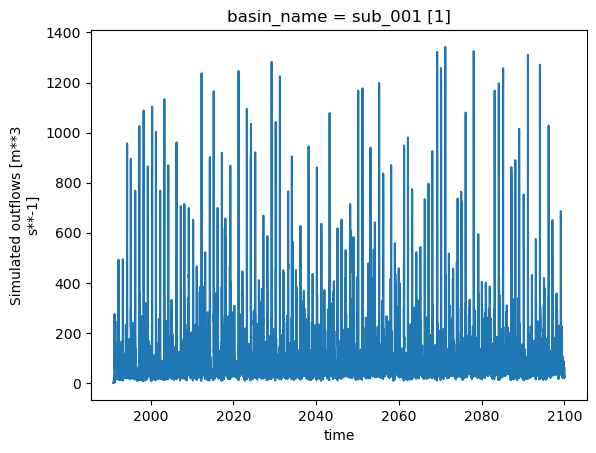

In [8]:
from copy import deepcopy

model_config_fut = deepcopy(model_config)
model_config_fut["start_date"] = "1991-01-01"
model_config_fut["end_date"] = "2099-12-30"
model_config_fut["meteo_file"] = ("/exec/rondeau/projets/INPACT/meteo_fut.nc",)
qfut = xhydro.modelling.hydrological_model(model_config_fut).run()
qfut.streamflow.hvplot()

In [9]:
qfut.to_netcdf("/exec/rondeau/projets/INPACT/qfut.nc")

In [1]:
import xarray as xr

qfut = xr.open_dataset("/exec/rondeau/projets/INPACT/qfut.nc")

# Frequency analysis

In [3]:
import xhydro as xh
import xhydro.frequency_analysis as xhfa

In [5]:
# Some examples
timeargs = {
    "annual": {},
}

In [7]:
# Here, we hide years with more than 15% of missing data.
ds_4fa = xh.indicators.get_yearly_op(
    qfut.sel(time=slice("1995", "2099")),
    op="max",
    timeargs=timeargs,
    missing="pct",
    missing_options={"tolerance": 0.15},
)

In [9]:
import hvplot.xarray
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(15, 10))
ds_4fa.streamflow_max_annual.dropna("time", how="all").hvplot(
    x="time", grid=True, widget_location="bottom"
)

HoloViews(Curve, height=300, sizing_mode='fixed', widget_location='bottom', width=700)

<Figure size 1500x1000 with 0 Axes>

In [51]:
from lmoments3 import distr

In [237]:
# To speed up the Notebook, we'll only perform the analysis on a subset of variables
params_hist = xhfa.local.fit(
    ds_4fa.load().sel(time=slice("1995", "2024")),
    distributions=[distr.gev, distr.gum, distr.nor],
    method="MLE",
)
params_fut = xhfa.local.fit(
    ds_4fa.load().sel(time=slice("2070", "2099")),
    distributions=[distr.gev, distr.gum, distr.nor],
    method="MLE",
)

In [238]:
params_hist["scipy_dist"] = ["genextreme", "gumbel_r", "norm"]
params_fut["scipy_dist"] = ["genextreme", "gumbel_r", "norm"]

In [239]:
criteria_hist = xhfa.local.criteria(ds_4fa.sel(time=slice("1995", "2024")), params_hist)
criteria_hist = str(
    criteria_hist.isel(
        scipy_dist=criteria_hist.streamflow_max_annual.sel(criterion="bic")
        .argmin()
        .values
    ).scipy_dist.values
)
criteria_hist

'genextreme'

In [240]:
criteria_fut = xhfa.local.criteria(ds_4fa.sel(time=slice("2070", "2099")), params_fut)
criteria_fut = str(
    criteria_fut.isel(
        scipy_dist=criteria_fut.streamflow_max_annual.sel(criterion="bic")
        .argmin()
        .values
    ).scipy_dist.values
)
criteria_fut

'genextreme'

In [241]:
rp_hist = xhfa.local.parametric_quantiles(
    params_hist.where(params_hist.scipy_dist == criteria_hist, drop=True),
    t=[2, 5, 10, 20, 50, 100, 350],
)
rp_fut = xhfa.local.parametric_quantiles(
    params_fut.where(params_fut.scipy_dist == criteria_fut, drop=True),
    t=[2, 5, 10, 20, 50, 100, 350],
)

In [242]:
data_hist = xhfa.local._prepare_plots(
    params_hist, xmin=1, xmax=1000, npoints=50, log=True
)
data_fut = xhfa.local._prepare_plots(
    params_fut, xmin=1, xmax=1000, npoints=50, log=True
)

In [243]:
pp = xhfa.local._get_plotting_positions(ds_4fa[["streamflow_max_annual"]])

In [249]:
# Let's plot the observations
p1h = (
    data_hist.streamflow_max_annual.where(
        params_hist.scipy_dist == criteria_hist, drop=True
    )
    .mean(dim="scipy_dist")
    .hvplot(x="return_period", grid=True, groupby=[], logx=True, color="k")
)
p1f = (
    data_fut.streamflow_max_annual.where(
        params_fut.scipy_dist == criteria_fut, drop=True
    )
    .mean(dim="scipy_dist")
    .hvplot(x="return_period", grid=True, groupby=[], logx=True, color="r")
)
data_hist.streamflow_max_annual.where(
    params_hist.scipy_dist == criteria_hist, drop=True
).mean(dim="scipy_dist").hvplot(
    x="return_period", grid=True, groupby=[], logx=True, color="k"
) * data_fut.streamflow_max_annual.where(
    params_fut.scipy_dist == criteria_fut, drop=True
).mean(
    dim="scipy_dist"
).hvplot(
    x="return_period", grid=True, groupby=[], logx=True, color="r"
)

:Overlay
   .Curve.I  :Curve   [return_period]   (streamflow_max_annual)
   .Curve.II :Curve   [return_period]   (streamflow_max_annual)

In [250]:
# Let's now plot the distributions
p2h = pp.sel(time=slice("1995", "2024")).hvplot.scatter(
    x="streamflow_max_annual_pp",
    y="streamflow_max_annual",
    grid=True,
    groupby=[],
    logx=True,
    color="k",
)
p2f = pp.sel(time=slice("2070", "2099")).hvplot.scatter(
    x="streamflow_max_annual_pp",
    y="streamflow_max_annual",
    grid=True,
    groupby=[],
    logx=True,
    color="r",
)
pp.sel(time=slice("1995", "2024")).hvplot.scatter(
    x="streamflow_max_annual_pp",
    y="streamflow_max_annual",
    grid=True,
    groupby=[],
    logx=True,
    color="k",
) * pp.sel(time=slice("2070", "2099")).hvplot.scatter(
    x="streamflow_max_annual_pp",
    y="streamflow_max_annual",
    grid=True,
    groupby=[],
    logx=True,
    color="r",
)

:Overlay
   .Scatter.I  :Scatter   [streamflow_max_annual_pp]   (Maximum of variable)
   .Scatter.II :Scatter   [streamflow_max_annual_pp]   (Maximum of variable)

In [251]:
# And now combining the plots
p1h * p2h

:Overlay
   .Curve.I   :Curve   [return_period]   (streamflow_max_annual)
   .Scatter.I :Scatter   [streamflow_max_annual_pp]   (Maximum of variable)

In [252]:
p1f * p2f

:Overlay
   .Curve.I   :Curve   [return_period]   (streamflow_max_annual)
   .Scatter.I :Scatter   [streamflow_max_annual_pp]   (Maximum of variable)

In [253]:
p1h * p2h * p1f * p2f

:Overlay
   .Curve.I    :Curve   [return_period]   (streamflow_max_annual)
   .Scatter.I  :Scatter   [streamflow_max_annual_pp]   (Maximum of variable)
   .Curve.II   :Curve   [return_period]   (streamflow_max_annual)
   .Scatter.II :Scatter   [streamflow_max_annual_pp]   (Maximum of variable)

In [235]:
import xhydro

deltas = xhydro.cc.compute_deltas(rp_fut, rp_hist, kind="%", rename_variables=False)
deltas.squeeze().streamflow_max_annual.load()

<xarray.DataArray 'streamflow_max_annual' (return_period: 7)> Size: 56B
array([-8.19436001,  2.33548283,  7.23592603, 10.99677995, 14.84283257,
       17.12464861, 20.22633281])
Coordinates:
    horizon        <U9 36B '2070-2099'
    basin_name     <U7 28B 'sub_001'
    scipy_dist     <U10 40B 'genextreme'
  * return_period  (return_period) int64 56B 2 5 10 20 50 100 350
    p_quantile     (return_period) float64 56B 0.5 0.8 0.9 0.95 0.98 0.99 0.9971
Attributes: (12/14)
    units:                 %
    original_long_name:    Maximum of variable
    cell_methods:          dparams: ppf
    history:               [2024-12-05 16:14:55] pct. delta vs. 1995-2024 - x...
    original_description:  Annual maximum of variable (annual).
    long_name:             Return period: pct. delta compared to 1995-2024.
    ...                    ...
    estimator:             Maximum likelihood
    scipy_dist:            ['genextreme']
    min_years:             None
    mode:                  max
    delta_kind:            pct.
    delta_reference:       1995-2024